In [ ]:
!pip install transformers accelerate bitsandbytes datasets peft --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install scikit-learn seaborn matplotlib --quiet

In [ ]:
!pip install seaborn matplotlib --quiet

In [ ]:
import torch
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,  # or AutoModelForSequenceClassification, depending on your use
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    prepare_model_for_kbit_training
)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# You can define your save path in Drive
SAVE_MODEL_PATH = "/content/drive/MyDrive/HIT/nlp_seminar_idan/yam_trained_model"
SAVE_MODEL_PATH = "/content/drive/MyDrive/HIT/nlp_seminar_idan/dictalm"


Mounted at /content/drive


In [ ]:
import pandas as pd
data_path = "/content/drive/MyDrive/HIT/nlp_seminar/bgz_slim_idan3.xlsx"
df = pd.read_excel(data_path)
df.head(3)
save_model_path = "/content/drive/MyDrive/HIT/nlp_seminar/dictalm2"


# prompt: select from df all the entries where 'סיווג 2' is not empty
lable_name ='סיווג 1'
df_not_empty = df[df[lable_name].notna()]
df_not_empty.head(3)
texts = df_not_empty['גוף המסמך'].to_list()
labels = df_not_empty[lable_name].to_list()
labels = [int(a) for a in labels]

import numpy as np
from sklearn.model_selection import train_test_split
# Split the data into training and temporary sets (80% train, 20% temp)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [ ]:
from datasets import Dataset, DatasetDict

def create_dataset_dict(
    train_texts, train_labels,
    test_texts, test_labels,
    text_column="text", label_column="label"
):
    """
    Create a Hugging Face DatasetDict with "train" and "test" splits
    from two pairs of lists: train_texts, train_labels, test_texts, test_labels.

    Args:
        train_texts (List[str]): A list of text strings for training.
        train_labels (List[int] or List[str]): A list of labels for training.
        test_texts (List[str]): A list of text strings for testing.
        test_labels (List[int] or List[str]): A list of labels for testing.
        text_column (str): The name of the text column in the resulting dataset.
        label_column (str): The name of the label column in the resulting dataset.

    Returns:
        datasets.DatasetDict
    """
    train_data = {
        text_column: train_texts,
        label_column: train_labels,
    }
    test_data = {
        text_column: test_texts,
        label_column: test_labels,
    }
    dataset_dict = DatasetDict({
        "train": Dataset.from_dict(train_data),
        "test": Dataset.from_dict(test_data),
    })

    return dataset_dict

raw_datasets = create_dataset_dict(train_texts, train_labels, test_texts, test_labels)

In [ ]:
from transformers import AutoTokenizer

model_name = 'dicta-il/dictalm2.0'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# We usually rename or set the label column to "labels" for the Trainer
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# For text classification, we typically remove other columns except "input_ids", "attention_mask", "labels"
tokenized_datasets = tokenized_datasets.remove_columns(
    [col for col in tokenized_datasets["train"].column_names if col not in ["input_ids", "attention_mask", "labels"]]
)


tokenizer_config.json:   0%|          | 0.00/932 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/513k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.86M [00:00<?, ?B/s]

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/46 [00:00<?, ? examples/s]

In [ ]:
model_name = 'dicta-il/dictalm2.0'
num_classes = 2 # <-- adapt to however many classes you have
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",           # "nf4" is often recommended, or "fp4"
    bnb_4bit_use_double_quant=True,      # can help with stability
    bnb_4bit_compute_dtype=torch.float16  # or torch.float32 if you have enough GPU mem
)

# If you're doing classification:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
    num_labels=num_classes  # <-- adapt to however many classes you have
)



config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictalm2.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Step 1: Prepare model for k-bit training (un-freezes certain norms, sets some layers to fp32)
model = prepare_model_for_kbit_training(model)

# Step 2: Define a LoRA config
peft_config = LoraConfig(
    r=8,                          # rank; common default is 8 or 16
    lora_alpha=32,                # scaling factor
    lora_dropout=0.1,             # dropout
    bias="none",                  # how to handle bias
    task_type=TaskType.SEQ_CLS,   # or TaskType.CAUSAL_LM if you're doing causal language modeling
    target_modules=["q_proj","v_proj"]
    # The 'target_modules' will vary by architecture; for Mistral or LLaMA-like models, "q_proj" and "v_proj" are typical
)

# Step 3: Wrap the model with LoRA
model = get_peft_model(model, peft_config)
print("LoRA model ready.")


LoRA model ready.


In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np


training_args = TrainingArguments(
    output_dir="./content/drive/MyDrive/HIT/nlp_seminar/outputs",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,           # for demo
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    logging_steps=50,
    learning_rate=2e-5,           # might need tuning
    fp16=True,
    # If you prefer 8-bit optim, you can add "optim='adamw_bnb_8bit'" (requires bitsandbytes).
)




# 2) Define a compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")    # or "macro", "micro", etc.
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

tokenizer.pad_token = tokenizer.eos_token
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # <--- Pass here
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-57bc81684f0f>:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
torch.cuda.empty_cache()
train_result = trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.393500,0.751279,0.847826,0.833157,0.829692,0.847826
2,1.095300,1.669603,0.804348,0.808798,0.814075,0.804348
3,1.374800,1.160910,0.804348,0.808798,0.814075,0.804348


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


In [ ]:
# eval_result = trainer.evaluate()
# print("Evaluation results:", eval_result)


Evaluation results: {'eval_loss': 2.3384227752685547, 'eval_accuracy': 0.7272727272727273, 'eval_f1': 0.6638383838383838, 'eval_precision': 0.6133557800224467, 'eval_recall': 0.7272727272727273, 'eval_runtime': 27.6945, 'eval_samples_per_second': 1.192, 'eval_steps_per_second': 1.192, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!pip install evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/84.0 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺ 81.9/84.0 kB 2.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:00


In [ ]:


# Option 2: Save directly into your Google Drive
SAVE_MODEL_PATH = "/content/drive/MyDrive/HIT/nlp_seminar/dictalm2v2"
trainer.save_model(SAVE_MODEL_PATH)
tokenizer.save_pretrained(SAVE_MODEL_PATH)

print(f"Model and tokenizer saved to {SAVE_MODEL_PATH}")


Model and tokenizer saved to /content/drive/MyDrive/HIT/nlp_seminar/dictalm2v2


In [ ]:
unlabeled_df = df[df[lable_name].isna()]

In [ ]:
def predict_single(text):
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    # Move to GPU if available
    inputs = {k: v.to("cuda") for k, v in inputs.items()} if torch.cuda.is_available() else inputs

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred = logits.argmax(dim=-1).item()
    return pred

#### checking test set

actual: 1.0, predicted: 0
['\n\n\n\n\nפסק-דין בתיק בג"ץ  3512/04\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n  \n  בבית המשפט\n  העליון\xa0\xa0 בשבתו כבית משפט גבוה לצדק\n  \n \n\n\n\n\n\xa0\n\n\n\n\n \n  \n  בג"ץ\xa0\n  3512/04\n  \n \n\n\n\n\n\xa0\n\n\n\n\n \n  \n  בפני:\xa0\xa0 \n  \n  \n  כבוד השופטת ד\' ביניש\n  \n \n \n  \n  \xa0\n  \n  \n  כבוד השופטת א\' פרוקצ\'יה\n  \n \n \n  \n  \xa0\n  \n  \n  כבוד השופטת ע\' ארבל\n  \n \n\n\n\n\n\xa0\n\n\n\n\n \n  \n  העותרת:\n  \n  \n  מיכל שזיפי\n  \n \n\n\n\n\n\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 \n\n\n\n\n \n  \n  \xa0\n  \n  \n  נ\xa0 ג\xa0 ד\n  \n \n\n\n\n\n\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\x

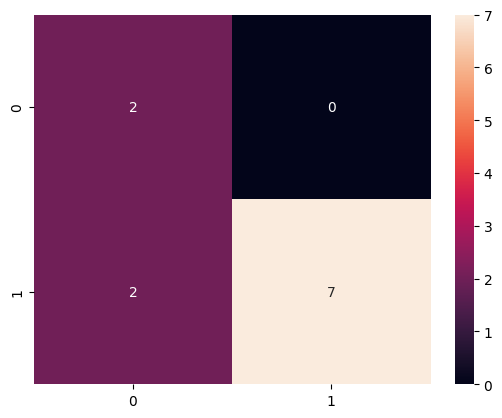

In [ ]:
test_df = df[df['test'].notna()]
texts = test_df['גוף המסמך'].to_list()
labels = test_df['test'].to_list()
preds = []
for t,actual_label in zip(texts,labels):
  p = predict_single(t)
  preds.append(p)
  if actual_label != p:
    print(f"actual: {actual_label}, predicted: {p}")
    print(t)

#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, preds)
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt='d')
plt.show()


In [ ]:
!pip install seaborn matplotlib --quiet

actual: 1, predicted: 0
['פסק דין בתיק בג"ץ 5722/12 בבית המשפט העליון בשבתו כבית משפט גבוה לצדק בג"ץ 5722/12 לפני: כבוד הנשיאה (בדימ\') מ\' נאור כבוד המשנה לנשיאה ח\' מלצר כבוד השופט א\' שהם העותרים: 1. אסעד אבו גוש 2. הוועד הציבורי נגד עינויים בישראל נגד המשיבים: 1. היועץ המשפטי לממשלה 2. פרקליט המדינה 3. חוקרי שירות הביטחון הכללי עתירה למתן צו על תנאי תאריך הישיבה: י"ג באלול התשע"ז (4.9.2017) בשם העותרים: עו"ד סמדר בן נתן בשם המשיבים: עו"ד מיטל בוכמן שינדל פסק דין השופט א\' שהם: 1. לפנינו עתירה במסגרתה התבקשנו ליתן צו על תנאי, המופנה כלפי המשיבים 1 ו-2, אשר יורה למחלקה לחקירות שוטרים (להלן: מח"ש) לפתוח לאלתר בחקירה פלילית נגד חוקרי שירות הבטחון הכללי (להלן: שב"כ), שהיו מעורבים בחקירתו של העותר 1 (להלן: העותר). זאת, בחשד לשימוש בעינויים ובהתעללות במהלך חקירתו של העותר, ועל פי המתחייב, לטענת העותרים, מסעיף 49טו1(א) לפקודת המשטרה [נוסח חדש], התשל"א - 1971 (להלן: פקודת המשטרה). עוד ביקשו העותרים להורות על העמדתם לדין של החוקרים על יסוד החומר המצוי בידי המשיבים 1 ו-2, או לאחר ניהול חקירה 

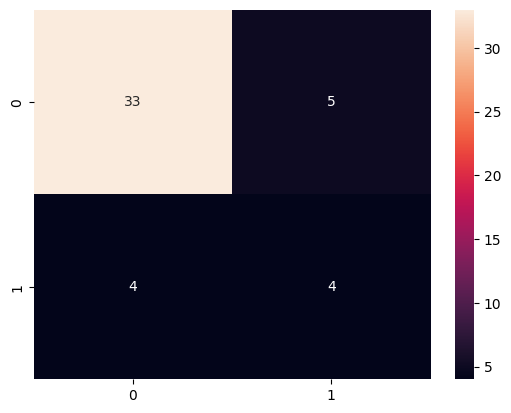

In [ ]:
preds = []
for t,actual_label in zip(test_texts,test_labels):
  p = predict_single(t)
  preds.append(p)
  if actual_label != p:
    print(f"actual: {actual_label}, predicted: {p}")
    print(t)

#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, preds)
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [ ]:
predictions = []
for idx, row in df.iterrows():
    text = row["גוף המסמך"]
    if text is None:
        pred_label = None
    else:
      try:
        pred_label = predict_single(text)
      except:
        pred_label = None
        print(text)
    predictions.append(pred_label)
    if idx % 1000 == 0:
        print(f"Processed {idx} rows")

df["prediction"] = predictions


Processed 0 rows
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Processed 1000 rows
nan
nan
nan
nan
nan
Processed 2000 rows
nan
nan
nan
nan
nan
Processed 3000 rows
Processed 4000 rows
Processed 5000 rows
Processed 6000 rows
Processed 7000 rows
nan
nan
nan
nan
nan
nan
Processed 8000 rows
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Processed 9000 rows
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Processed 10000 rows
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Processed 11000 rows
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Processed 12000 rows
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Processed 13000 rows
nan
nan
nan
nan
nan
nan
nan
Processed 14000 rows
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Processed 15000 rows
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Proce

In [ ]:
# prompt: save excel from df

# Save the DataFrame with predictions to an Excel file
df.to_excel('/content/drive/MyDrive/HIT/nlp_seminar/dictalm2v2/predicted_binary_classification_df2.xlsx', index=False)

### EDA

In [ ]:
import pandas as pd
data_path_eda = '/content/drive/MyDrive/HIT/nlp_seminar/dictalm2v2/predicted_binary_classification_df2 8.xlsx'
df_eda = pd.read_excel(data_path_eda)

In [ ]:
df_eda.head(3)

,מספר תיק,גוף המסמך,תיאור בקשה,סטטוס דיון,שם הליך,סיווג 1,סיווג 2,הערות,סיווג_מסמך7,הערת סיווג_מסמך7,סיווג_מסמך3,הערות_מסמך3,prediction
0,6396/18,"['פסק דין בתיק בג""ץ 6396/18 בבית המשפט העליון ...","['צו ביניים', 'למתן החלטה או פסק דין', 'לשנות ...",['נדחה'],"בג""צ 6396/18 ועד ראשי המככללות האקדמיות הציבור...",0.0,0.0,NaN,0,לא מתאים לשום קריטריון.,0,NaN,0.0
1,1431/18,"['פסק דין בתיק בג""ץ 1431/18 בבית המשפט העליון ...","['פטור מאגרה', 'למתן רשות להגיב']",NaN,"בג""צ 1431/18",0.0,0.0,NaN,0,לא מתאים לשום קריטריון.,0,NaN,0.0
2,4099/18,"['פסק דין בתיק בג""ץ 4099/18 בבית המשפט העליון ...","['קביעת מועד', 'לשנות מועד הגשה']",['התקיים'],"בג""צ 4099/18 בלאל ברכאת סולימאנ סלהב נ. ראש ...",0.0,0.0,NaN,0,לא מתאים לשום קריטריון.,0,NaN,0.0


In [ ]:
data_path = "/content/drive/MyDrive/HIT/nlp_seminar/all_data_bgz.xlsx"
df_all = pd.read_excel(data_path)
df_all.head(2)

,מספר תיק,מספר החלטות בתיק,שם הליך,שנת פתיחת ההליך,מספר הליך,סוג הליך,פירוט סוג הליך,תיק חסוי,תאריך אירוע אחרון,משך התיק בימים,...,סוג גורם שיפוטי דלמטה,סוג בית משפט דלמטה,מקום בית משפט דלמטה,הליך מאוחד,שמות ההליכים המאוחדים,צדדים נוספים,מספר תיק מלא,מספר השופטים,ניתנה החלטה כמבוקש הבקשה,Year
0,6396/18,7,"בג""צ 6396/18 ועד ראשי המככללות האקדמיות הציבור...",2018,"בג""צ 6396/18","בג""צ",בית משפט גבוה לצדק,0.0,2018-12-02,84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
1,1431/18,4,"בג""צ 1431/18",2018,"בג""צ 1431/18","בג""צ",בית משפט גבוה לצדק,0.0,2018-05-31,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018


In [ ]:
#join df and df_eda based on 'מספר תיק'
df = df_all.merge(df_eda, on='מספר תיק', how='left')

In [ ]:
# df.to_excel('/content/drive/MyDrive/HIT/nlp_seminar/dictalm2v2/predicted_binary_classification_df_eda.xlsx', index=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49990 entries, 0 to 49989
Columns: 152 entries, מספר תיק to prediction
dtypes: float64(12), int64(6), object(134)
memory usage: 58.0+ MB


In [ ]:
df.describe()

,מספר החלטות בתיק,שנת פתיחת ההליך,תיק חסוי,משך התיק בימים,מספר גורמים שיפוטיים במותב,מספר צדדים בתיק,מספר תיקי דלמטה בתיק,מספר דיונים בתיק,מספר אירועים בתיק,מספר אישורי מסירה בתיק,מספר בקשות בתיק,הליך מאוחד,Year,סיווג 1,סיווג 2,סיווג_מסמך7,סיווג_מסמך3,prediction
count,49990.000000,49990.000000,49342.000000,49990.000000,49359.000000,49270.000000,49270.000000,49270.000000,49270.000000,49270.000000,49270.000000,2119.0,49990.000000,203.000000,161.000000,49990.000000,49990.000000,49523.000000
mean,4.432607,2007.675775,0.001459,252.078756,2.012014,4.522752,0.189162,1.345362,19.283661,18.945606,3.793059,1.0,2007.676535,0.211823,0.689441,0.130706,0.000540,0.334410
std,4.822896,7.418345,0.038172,468.200815,1.085097,4.242071,0.459552,1.946541,20.254668,41.056982,6.553369,0.0,7.416232,0.409610,1.492632,0.687912,0.023234,0.471789
min,1.000000,1969.000000,0.000000,-245.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1997.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2002.000000,0.000000,15.000000,1.000000,3.000000,0.000000,0.000000,8.000000,5.000000,0.000000,1.0,2002.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2006.000000,0.000000,79.000000,1.000000,4.000000,0.000000,1.000000,13.000000,10.000000,2.000000,1.0,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,2014.000000,0.000000,315.000000,3.000000,5.000000,0.000000,2.000000,23.000000,19.000000,5.000000,1.0,2014.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,109.000000,2022.000000,1.000000,36547.000000,14.000000,263.000000,16.000000,27.000000,426.000000,2040.000000,161.000000,1.0,2022.000000,1.000000,6.000000,5.000000,1.000000,1.000000


In [ ]:
df['prediction'].describe()

,prediction
count,49523.000000
mean,0.334410
std,0.471789
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


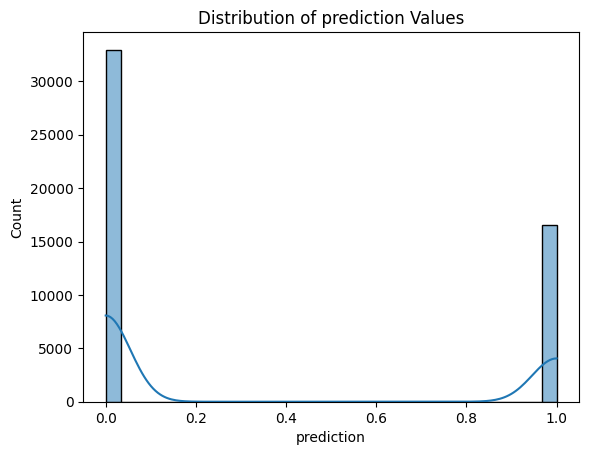

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df['prediction'], kde=True, bins=30)
plt.title("Distribution of prediction Values")
plt.show()

In [ ]:
# prompt: get all numerical columns

import pandas as pd
import numpy as np
# Assuming 'df' is your DataFrame (as defined in your provided code)
numerical_cols = df.select_dtypes(include=np.number).columns
numerical_cols

Index(['מספר החלטות בתיק', 'שנת פתיחת ההליך', 'תיק חסוי', 'משך התיק בימים',
       'מספר גורמים שיפוטיים במותב', 'מספר צדדים בתיק', 'מספר תיקי דלמטה בתיק',
       'מספר דיונים בתיק', 'מספר אירועים בתיק', 'מספר אישורי מסירה בתיק',
       'מספר בקשות בתיק', 'הליך מאוחד', 'Year', 'סיווג 1', 'סיווג 2',
       'סיווג_מסמך7', 'סיווג_מסמך3', 'prediction'],
      dtype='object')

<Axes: >

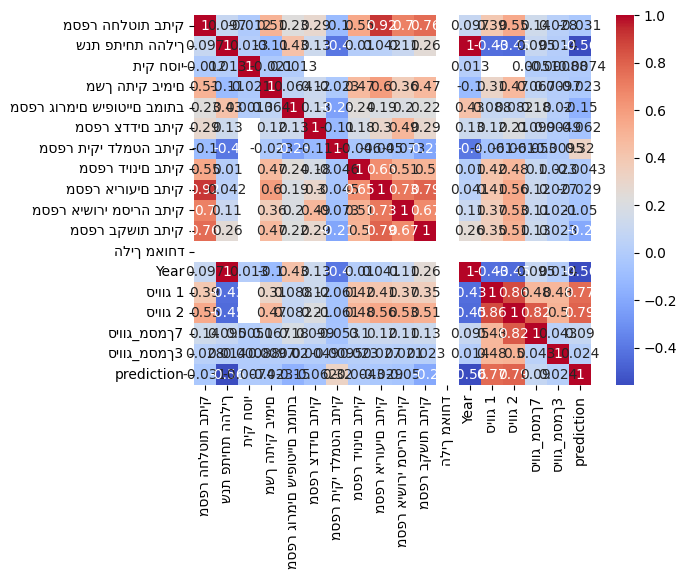

In [ ]:
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [ ]:
# prompt: get all non numerical columns

import pandas as pd
import numpy as np



# Get a list of all non-numerical columns
non_numerical_cols = df.select_dtypes(exclude=np.number).columns.tolist()

non_numerical_cols

['מספר תיק',
 'שם הליך_x',
 'מספר הליך',
 'סוג הליך',
 'פירוט סוג הליך',
 'תאריך אירוע אחרון',
 'תאריך הגשה',
 'מתוקן סוג הליך',
 'תאריך יצוא התיק',
 'תאריך יצוא הקובץ',
 'תאריך נרמול הקובץ',
 'שם הקובץ',
 'קישור לתיק',
 'שם גורם שיפוטי',
 'תואר גורם שיפוטי',
 'ID',
 'שם השופט',
 'שם השופט מנורמל',
 'שם משפחה מנורמל',
 'שם פרטי מנורמל',
 'מגדר',
 'לאום',
 'דת',
 'קבוצה דתית',
 'שיוך עדתי',
 'ארץ/איזור לידה',
 'שנת לידה',
 'יישוב מגורים מרכזי בילדות',
 'דירוג חברתי כלכלי של  יישוב מגורים מרכזי בילדות',
 'בית ספר תיכון',
 'סוג החינוך',
 'מוסד חינוך משפטי עיקרי',
 'שנת סיום התואר הראשון במשפטים',
 'סוג השכלה משפטית מתקדמת',
 'מוסד חינוך משפטי מתקדם',
 'שנת קבלת התואר המתקדם',
 'מקום התמחות',
 'שנת הסמכה כעורך/ת דין',
 'המשרה האחרונה טרם המינוי לשיפוט',
 'משרה שיפוטית 1',
 'שם בית המשפט במשרה שיפוטית 1',
 'שנת מינוי למשרה שיפוטית 1',
 'משרה שיפוטית 2',
 'שם בית המשפט במשרה שיפוטית 2',
 'שנת מינוי למשרה שיפוטית 2',
 'משרה שיפוטית 3',
 'שם בית המשפט במשרה שיפוטית 3',
 'שנת מינוי למשרה שיפוטי

###classifiy 7

In [ ]:
import pandas as pd
data_path = "/content/drive/MyDrive/HIT/nlp_seminar/bgz_slim_idan2.xlsx"
df2 = pd.read_excel(data_path)

# prompt: select from df all the entries where 'סיווג 2' is not empty
lable_name ='סיווג 2'
df_not_empty = df2[df2[lable_name].notna()]
df_not_empty.head(3)
texts = df_not_empty['גוף המסמך'].to_list()
labels = df_not_empty['סיווג 2'].to_list()
labels = [int(a) for a in labels]

import numpy as np
from sklearn.model_selection import train_test_split
# Split the data into training and temporary sets (80% train, 20% temp)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [ ]:
raw_datasets = create_dataset_dict(train_texts, train_labels, test_texts, test_labels)

In [ ]:
from transformers import AutoTokenizer

model_name = "yam-peleg/Hebrew-Mistral-7B-200K"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# We usually rename or set the label column to "labels" for the Trainer
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# For text classification, we typically remove other columns except "input_ids", "attention_mask", "labels"
tokenized_datasets = tokenized_datasets.remove_columns(
    [col for col in tokenized_datasets["train"].column_names if col not in ["input_ids", "attention_mask", "labels"]]
)


In [ ]:
model_name = "yam-peleg/Hebrew-Mistral-7B-200K"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",           # "nf4" is often recommended, or "fp4"
    bnb_4bit_use_double_quant=True,      # can help with stability
    bnb_4bit_compute_dtype=torch.float16  # or torch.float32 if you have enough GPU mem
)

# If you're doing classification:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
    num_labels=7  # <-- adapt to however many classes you have
)



In [ ]:
# Step 1: Prepare model for k-bit training (un-freezes certain norms, sets some layers to fp32)
model = prepare_model_for_kbit_training(model)

# Step 2: Define a LoRA config
peft_config = LoraConfig(
    r=8,                          # rank; common default is 8 or 16
    lora_alpha=32,                # scaling factor
    lora_dropout=0.1,             # dropout
    bias="none",                  # how to handle bias
    task_type=TaskType.SEQ_CLS,   # or TaskType.CAUSAL_LM if you're doing causal language modeling
    target_modules=["q_proj","v_proj"]
    # The 'target_modules' will vary by architecture; for Mistral or LLaMA-like models, "q_proj" and "v_proj" are typical
)

# Step 3: Wrap the model with LoRA
model = get_peft_model(model, peft_config)
print("LoRA model ready.")


In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

training_args = TrainingArguments(
    output_dir="./content/drive/MyDrive/HIT/nlp_seminar/outputs",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,           # for demo
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    logging_steps=50,
    learning_rate=2e-5,           # might need tuning
    fp16=True,
    # If you prefer 8-bit optim, you can add "optim='adamw_bnb_8bit'" (requires bitsandbytes).
)




# 2) Define a compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")    # or "macro", "micro", etc.
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # <--- Pass here
)


In [ ]:
train_result = trainer.train()

In [ ]:
eval_result = trainer.evaluate()
print("Evaluation results:", eval_result)

In [ ]:
SAVE_MODEL_PATH = "/content/drive/MyDrive/HIT/nlp_seminar_idan/7class"
trainer.save_model(SAVE_MODEL_PATH)
tokenizer.save_pretrained(SAVE_MODEL_PATH)

print(f"Model and tokenizer saved to {SAVE_MODEL_PATH}")


In [ ]:
# prompt: close the current colab vm

!kill $(ps aux | grep 'python3' | awk '{print $2}')